<a href="https://colab.research.google.com/github/kutaydemiralay/Lane-Changing-Using-Controller-Design-with-Torque-Vectoring-and-Rear-Wheel-Steering/blob/main/LaneChange_with_Trailer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy matplotlib cvxpy


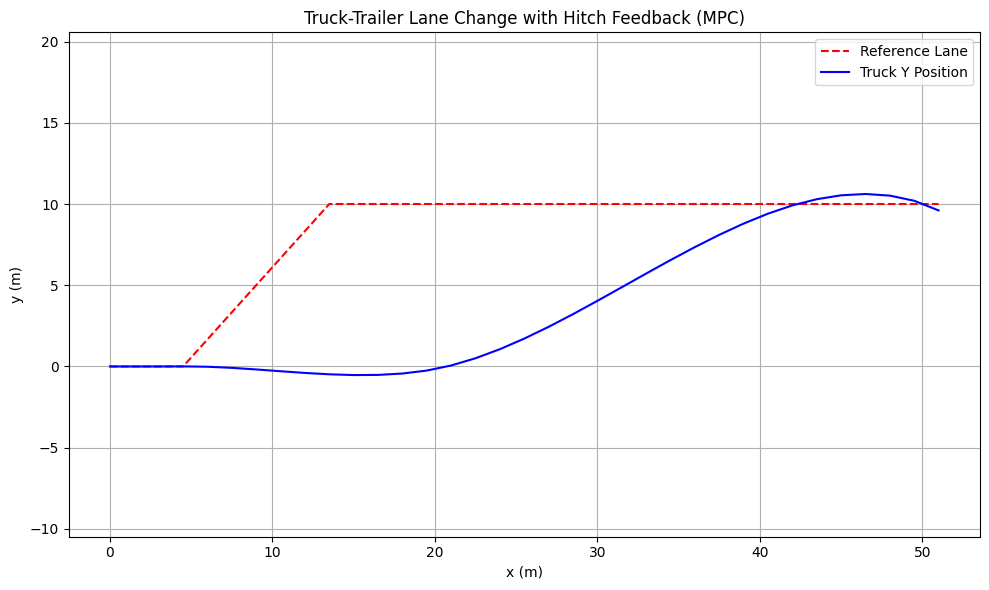

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# === Truck-Trailer Parameters ===
N = 34
dt = 0.1
v_long = 15.0
a = 1.5
b = 3.5
lt = 8.0
mT = 8000.0
mR = 4000.0
IzT = 12000.0
IzR = 8000.0
Cf = 100000.0
Cr = 100000.0
delta_max = np.deg2rad(20)
w_delta = 0.1
w_rel_yaw = 5.0
w_ddelta = 10.0

# === Initial Conditions ===
vy0, r0, y0, psi0 = 0.0, 0.0, 0.0, 0.0
psiR0, rR0 = 0.0, 0.0
x0 = np.array([vy0, r0, y0, psi0, psiR0, rR0])

# === Reference Lane Change ===
x_ref = np.linspace(0, N * dt * v_long, N + 1)
y_ref = np.zeros(N + 1)
hold_steps = 3
transition_length = 9.0
y_final = 10.0
for k in range(hold_steps, N + 1):
    dx = x_ref[k] - x_ref[hold_steps]
    y_ref[k] = (dx / transition_length) * y_final if dx <= transition_length else y_final

# === Optimization Variables ===
vy = cp.Variable(N + 1)
r = cp.Variable(N + 1)
y = cp.Variable(N + 1)
psi = cp.Variable(N + 1)
psiR = cp.Variable(N + 1)
rR = cp.Variable(N + 1)
delta = cp.Variable(N)

cost = 0
constraints = []

# === Dynamics and Constraints ===
for k in range(N):
    # Tire Forces
    Fyf = -Cf * (delta[k] - (vy[k] + a * r[k]) / v_long)
    Fyr = -Cr * ((-vy[k] + b * r[k] - lt * (rR[k] - r[k])) / v_long)
    FyR = -Cr * (lt * (rR[k] - r[k]) / v_long)

    # Dynamics
    constraints += [
        vy[k+1] == vy[k] + dt * ((Fyf + Fyr) / mT - v_long * r[k]),
        r[k+1]  == r[k]  + dt * ((a * Fyf - b * Fyr + lt * FyR) / IzT),
        y[k+1]  == y[k]  + dt * v_long * psi[k],
        psi[k+1] == psi[k] + dt * r[k],
        psiR[k+1] == psiR[k] + dt * rR[k],
        rR[k+1] == rR[k] - dt * (lt * FyR / IzR),
        cp.abs(delta[k]) <= delta_max
    ]

    # Cost Function
    cost += 2 * cp.square(y[k+1] - y_ref[k+1])
    cost += w_delta * cp.square(delta[k])
    cost += w_rel_yaw * cp.square(psi[k+1] - psiR[k+1])
    if k < N - 1:
        cost += w_ddelta * cp.square(delta[k+1] - delta[k])

# Initial Conditions
constraints += [
    vy[0] == x0[0],
    r[0] == x0[1],
    y[0] == x0[2],
    psi[0] == x0[3],
    psiR[0] == x0[4],
    rR[0] == x0[5]
]

# === Solve ===
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(solver=cp.OSQP)

# === Plot Result ===
plt.figure(figsize=(10, 6))
plt.plot(x_ref, y_ref, 'r--', label='Reference Lane')
plt.plot(x_ref, y.value, 'b-', label='Truck Y Position')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Truck-Trailer Lane Change with Hitch Feedback (MPC)')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()


In [11]:
# === Compute Average Absolute Lateral Error ===
avg_abs_lateral_error = np.mean(np.abs(y.value - y_ref))
print(f"Average Absolute Lateral Error: {avg_abs_lateral_error:.4f} meters")


Average Absolute Lateral Error: 4.4856 meters


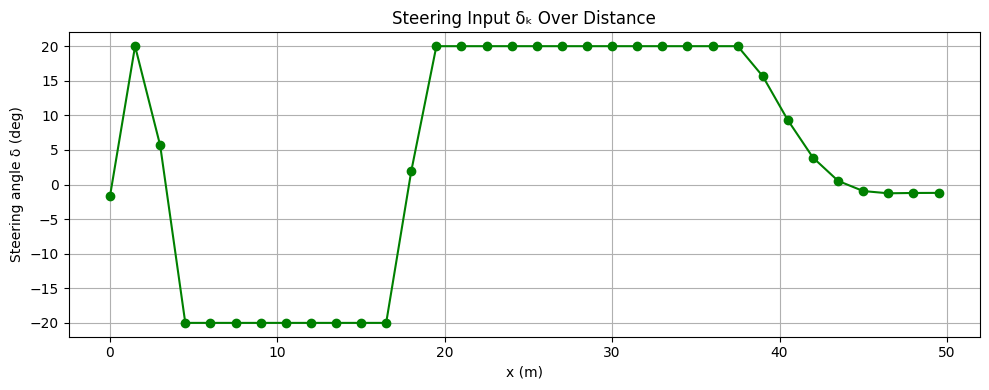

In [12]:
# Plot steering input over x_ref
plt.figure(figsize=(10, 4))
plt.plot(x_ref[:-1], np.rad2deg(delta.value), 'g-', marker='o')
plt.xlabel('x (m)')
plt.ylabel('Steering angle δ (deg)')
plt.title('Steering Input δₖ Over Distance')
plt.grid(True)
plt.tight_layout()
plt.show()


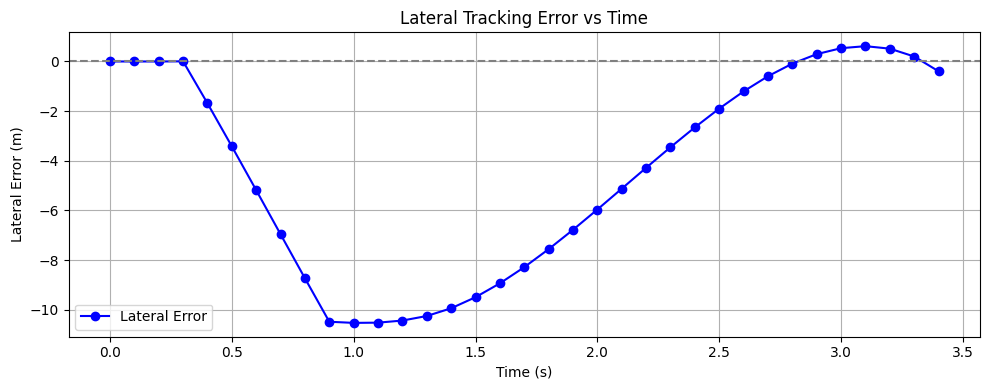

In [13]:
# === Compute and Plot Lateral Tracking Error ===
time = np.linspace(0, N * dt, N + 1)
lateral_error = y.value - y_ref  # elementwise difference

plt.figure(figsize=(10, 4))
plt.plot(time, lateral_error, 'b-', marker='o', label='Lateral Error')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Lateral Error (m)')
plt.title('Lateral Tracking Error vs Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Torque

In [14]:

total_steering_energy = np.sum(delta.value**2)


print(f"Total Steering Effort: {total_steering_energy:.4f}")



Total Steering Effort: 2.9216
